# ML Project - Fall 2021
---
In this project we are going to predict the behavior of customers when cliking on an advertisements that whether they buy that product or not.

In [1]:
import pandas as pd
import numpy as np
# import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# data = pd.read_csv('train_dataset.csv')
data = pd.read_csv('https://raw.githubusercontent.com/a80-abbasi/ML_Project/main/train_dataset.csv')
data.head()

,Sale,SalesAmountInEuro,time_delay_for_conversion,click_timestamp,nb_clicks_1week,product_price,product_age_group,device_type,audience_id,product_gender,product_brand,product_category(1),product_category(2),product_category(3),product_category(4),product_category(5),product_category(6),product_category(7),product_country,product_id,product_title,partner_id,user_id
0,0,-1.0,-1,2020-08-04 04:07:56,-1,0.0,-1,7E56C27BFF0305E788DA55A029EC4988,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,B69E439E41E0BEAD764ABF16D7FD96C9,-1,E3DDEB04F8AFF944B11943BB57D2F620,5E2C678F6586B67F61A377E1534E01FC
1,0,-1.0,-1,2020-08-04 01:47:40,-1,0.0,-1,7E56C27BFF0305E788DA55A029EC4988,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,404D3D9D03297504F3509032DCFA02F0,-1,E3DDEB04F8AFF944B11943BB57D2F620,E8247702C0DD294E0AE6B5B5E2F9E810
2,0,-1.0,-1,2020-08-04 16:54:31,-1,0.0,4C90FD52FC53D2C1C205844CB69575AB,FF2C446555E3822B0E0FC3406116E86D,-1,C45A9AC6D102ACAEEDF0D6F78636D84A,3DF2BEDE6A8FDFA7F97B97FFF6EF38CC,033E492229C2222EFAA16EE8A6462D8B,CD599E5A946D00A81A875E085F7EF1E8,-1,-1,-1,-1,-1,2AC62132FBCFA093B9426894A4BC6278,B09E51338E0EED59C5A859B13631C370,3DF2BEDE6A8FDFA7F97B97FFF6EF38CC 516EE9C34B839...,12E43E51784BDE3CB9E0EF6310A7D5C5,9FD001258907F541D497040C64383696
3,0,-1.0,-1,2020-08-03 20:34:28,-1,0.0,-1,D7D1FB49049702BF6338894757E0D959,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,080614393A57816D7A655695E2DBE728,-1,E3DDEB04F8AFF944B11943BB57D2F620,225741ACF2DBB2E5948268F5D5D352E6
4,0,-1.0,-1,2020-08-03 20:54:17,1064,0.0,4C90FD52FC53D2C1C205844CB69575AB,7E56C27BFF0305E788DA55A029EC4988,-1,1B491180398E2F0390E6A588B3BCE291,9B57D98465FD7D5AF39448DC29E95DC8,13C26D10258053889D75D9B9CA922EC7,346AC0DECB71FFDC9114236B419D7814,1E629AECC2FB9BEF43331CBE8F2D7C08,341C9BD18A3277E6B104CAFC177DE796,-1,-1,-1,989EEF92F2A525DD896557425EA7C4C7,350271BAFD7C7AAF6FB1424CF3DD4827,097C90F8BF5398AC7C486804F0801DEE E09E084DB8937...,F0FD783189F55BAFC331AD347EAE6863,160A90377E54124D0BD31DB6735F0B33


---
# 1. EDA

In this part we are going to get some insights about our data and find out what information each variable gives us. To do so we will follow bellow steps:
1. Understanding variables
2. Analyzing relationships between variables

In [3]:
data.dtypes

Sale                           int64
SalesAmountInEuro            float64
time_delay_for_conversion      int64
click_timestamp               object
nb_clicks_1week                int64
product_price                float64
product_age_group             object
device_type                   object
audience_id                   object
product_gender                object
product_brand                 object
product_category(1)           object
product_category(2)           object
product_category(3)           object
product_category(4)           object
product_category(5)           object
product_category(6)           object
product_category(7)            int64
product_country               object
product_id                    object
product_title                 object
partner_id                    object
user_id                       object
dtype: object

In [4]:
# int_cols = data.select_dtypes(int).columns
# data[int_cols] = data[int_cols].astype('Int64')

Two columns _'SalesAmountInEuro'_ and	_'time_delay_for_conversion'_ are -1 if product has been bought and a positive number otherwise. So they are equivalent to label (Sale) and we can't use them in training.

In [5]:
data = data.drop(columns=['SalesAmountInEuro',	'time_delay_for_conversion'], errors='ignore')

Inspecting _'click_timestamp'_ column:

In [6]:
data['click_timestamp'].apply(lambda x: x.split(' ')[0]).unique()

array(['2020-08-04', '2020-08-03'], dtype=object)

So it contains only two days. We change this column to a integer value indicating number of seconds from start of the day.

In [7]:
def get_seconds(time_str):
  _, hour = time_str.split(' ')
  t = list(map(int, hour.split(':')))
  return t[0] * 3600 + t[1] * 60 + t[2]

def get_day(time_str):
  date, _ = time_str.split(' ')
  return int(date.split('-')[-1])

data = data.merge(data['click_timestamp'].apply(lambda s: pd.Series({'click_day':get_day(s), 'click_second':get_seconds(s)})), left_index=True, right_index=True)

In [8]:
data.drop(columns=['click_timestamp'], errors='ignore', inplace=True)
data.head()

,Sale,nb_clicks_1week,product_price,product_age_group,device_type,audience_id,product_gender,product_brand,product_category(1),product_category(2),product_category(3),product_category(4),product_category(5),product_category(6),product_category(7),product_country,product_id,product_title,partner_id,user_id,click_day,click_second
0,0,-1,0.0,-1,7E56C27BFF0305E788DA55A029EC4988,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,B69E439E41E0BEAD764ABF16D7FD96C9,-1,E3DDEB04F8AFF944B11943BB57D2F620,5E2C678F6586B67F61A377E1534E01FC,4,14876
1,0,-1,0.0,-1,7E56C27BFF0305E788DA55A029EC4988,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,404D3D9D03297504F3509032DCFA02F0,-1,E3DDEB04F8AFF944B11943BB57D2F620,E8247702C0DD294E0AE6B5B5E2F9E810,4,6460
2,0,-1,0.0,4C90FD52FC53D2C1C205844CB69575AB,FF2C446555E3822B0E0FC3406116E86D,-1,C45A9AC6D102ACAEEDF0D6F78636D84A,3DF2BEDE6A8FDFA7F97B97FFF6EF38CC,033E492229C2222EFAA16EE8A6462D8B,CD599E5A946D00A81A875E085F7EF1E8,-1,-1,-1,-1,-1,2AC62132FBCFA093B9426894A4BC6278,B09E51338E0EED59C5A859B13631C370,3DF2BEDE6A8FDFA7F97B97FFF6EF38CC 516EE9C34B839...,12E43E51784BDE3CB9E0EF6310A7D5C5,9FD001258907F541D497040C64383696,4,60871
3,0,-1,0.0,-1,D7D1FB49049702BF6338894757E0D959,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,57A1D462A03BD076E029CF9310C11FC5,080614393A57816D7A655695E2DBE728,-1,E3DDEB04F8AFF944B11943BB57D2F620,225741ACF2DBB2E5948268F5D5D352E6,3,74068
4,0,1064,0.0,4C90FD52FC53D2C1C205844CB69575AB,7E56C27BFF0305E788DA55A029EC4988,-1,1B491180398E2F0390E6A588B3BCE291,9B57D98465FD7D5AF39448DC29E95DC8,13C26D10258053889D75D9B9CA922EC7,346AC0DECB71FFDC9114236B419D7814,1E629AECC2FB9BEF43331CBE8F2D7C08,341C9BD18A3277E6B104CAFC177DE796,-1,-1,-1,989EEF92F2A525DD896557425EA7C4C7,350271BAFD7C7AAF6FB1424CF3DD4827,097C90F8BF5398AC7C486804F0801DEE E09E084DB8937...,F0FD783189F55BAFC331AD347EAE6863,160A90377E54124D0BD31DB6735F0B33,3,75257


Then we continue our inspection and split columns to 'numerical' and 'categorical' to describe them.

In [9]:
target = 'Sale'
numerical_cols = ['click_second', 'click_day', 'nb_clicks_1week', 'product_price']
categorical_cols = list(set(data.columns) - set(numerical_cols) - set([target]))

Describing numerical columns:

In [10]:
data[numerical_cols].describe()

,click_second,click_day,nb_clicks_1week,product_price
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,44556.281060,3.574710,236.545830,10.929187
std,25540.243105,0.494389,1153.037285,65.574247
min,0.000000,3.000000,-1.000000,0.000000
25%,21209.750000,3.000000,-1.000000,0.000000
50%,47156.500000,4.000000,0.000000,0.000000
75%,66790.250000,4.000000,49.000000,0.000000
max,86399.000000,4.000000,25390.000000,3928.000000


As we can see the difference between 75% and max in _'nb_clicks_1week'_ is too much so there must exist some outlier records in this column

In [11]:
data[categorical_cols].nunique(axis=0)

product_country           17
product_category(7)        1
product_category(5)      442
audience_id             3182
product_id             45447
product_category(6)       89
product_brand           4770
device_type                4
product_category(1)       22
product_category(3)      699
product_title          27695
user_id                96766
product_gender            11
product_category(4)      910
product_age_group          9
product_category(2)      145
partner_id               183
dtype: int64

As we can see, product_category(7) contains only one value, -1. It means non of our records have product_category(7) and we can drop it.

In [12]:
data.drop(columns=['product_category(7)'], errors='ignore', inplace=True)
categorical_cols = list(set(categorical_cols).difference(['product_category(7)']))

Describing categorical columns:

In [13]:
data[categorical_cols].describe()

,product_country,product_category(5),audience_id,product_id,product_category(6),product_brand,device_type,product_category(1),product_category(3),product_title,user_id,product_gender,product_category(4),product_age_group,product_category(2),partner_id
count,100000,100000,100000,100000,100000,100000,100000,100000,100000,99739,100000,100000,100000,100000,100000,100000
unique,17,442,3182,45447,89,4770,4,22,699,27695,96766,11,910,9,145,183
top,57A1D462A03BD076E029CF9310C11FC5,-1,-1,-1,-1,-1,7E56C27BFF0305E788DA55A029EC4988,-1,-1,-1,953CC020FA7459BC16D81E311EDF271E,-1,-1,-1,-1,E3DDEB04F8AFF944B11943BB57D2F620
freq,38088,92009,71793,23714,98832,65800,52539,45502,52316,45502,48,75554,71222,75603,45517,31077


Note that _'product_title'_ has nan values.  
We replace all invalid values (-1 and 0 in _'product_price'_) to nan.

In [14]:
data = data.replace([-1, '-1'], np.nan).replace({'product_price': 0}, np.nan)
data.head()

,Sale,nb_clicks_1week,product_price,product_age_group,device_type,audience_id,product_gender,product_brand,product_category(1),product_category(2),product_category(3),product_category(4),product_category(5),product_category(6),product_country,product_id,product_title,partner_id,user_id,click_day,click_second
0,0.0,NaN,NaN,NaN,7E56C27BFF0305E788DA55A029EC4988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57A1D462A03BD076E029CF9310C11FC5,B69E439E41E0BEAD764ABF16D7FD96C9,NaN,E3DDEB04F8AFF944B11943BB57D2F620,5E2C678F6586B67F61A377E1534E01FC,4.0,14876.0
1,0.0,NaN,NaN,NaN,7E56C27BFF0305E788DA55A029EC4988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57A1D462A03BD076E029CF9310C11FC5,404D3D9D03297504F3509032DCFA02F0,NaN,E3DDEB04F8AFF944B11943BB57D2F620,E8247702C0DD294E0AE6B5B5E2F9E810,4.0,6460.0
2,0.0,NaN,NaN,4C90FD52FC53D2C1C205844CB69575AB,FF2C446555E3822B0E0FC3406116E86D,NaN,C45A9AC6D102ACAEEDF0D6F78636D84A,3DF2BEDE6A8FDFA7F97B97FFF6EF38CC,033E492229C2222EFAA16EE8A6462D8B,CD599E5A946D00A81A875E085F7EF1E8,NaN,NaN,NaN,NaN,2AC62132FBCFA093B9426894A4BC6278,B09E51338E0EED59C5A859B13631C370,3DF2BEDE6A8FDFA7F97B97FFF6EF38CC 516EE9C34B839...,12E43E51784BDE3CB9E0EF6310A7D5C5,9FD001258907F541D497040C64383696,4.0,60871.0
3,0.0,NaN,NaN,NaN,D7D1FB49049702BF6338894757E0D959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57A1D462A03BD076E029CF9310C11FC5,080614393A57816D7A655695E2DBE728,NaN,E3DDEB04F8AFF944B11943BB57D2F620,225741ACF2DBB2E5948268F5D5D352E6,3.0,74068.0
4,0.0,1064.0,NaN,4C90FD52FC53D2C1C205844CB69575AB,7E56C27BFF0305E788DA55A029EC4988,NaN,1B491180398E2F0390E6A588B3BCE291,9B57D98465FD7D5AF39448DC29E95DC8,13C26D10258053889D75D9B9CA922EC7,346AC0DECB71FFDC9114236B419D7814,1E629AECC2FB9BEF43331CBE8F2D7C08,341C9BD18A3277E6B104CAFC177DE796,NaN,NaN,989EEF92F2A525DD896557425EA7C4C7,350271BAFD7C7AAF6FB1424CF3DD4827,097C90F8BF5398AC7C486804F0801DEE E09E084DB8937...,F0FD783189F55BAFC331AD347EAE6863,160A90377E54124D0BD31DB6735F0B33,3.0,75257.0


In [15]:
# todo: converting values with low value_counts to 'other'

Now we map categorical values to integer values:

In [16]:
data[categorical_cols] = data[categorical_cols].astype('category')
column_categories = {}
for col in categorical_cols:
    column_categories[col] = data[col].cat.categories
    data[col] = data[col].cat.codes
data[categorical_cols] = data[categorical_cols].astype('Int64')
data = data.replace(-1, np.nan)
data.head()

,Sale,nb_clicks_1week,product_price,product_age_group,device_type,audience_id,product_gender,product_brand,product_category(1),product_category(2),product_category(3),product_category(4),product_category(5),product_category(6),product_country,product_id,product_title,partner_id,user_id,click_day,click_second
0,0.0,NaN,NaN,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4,32369,<NA>,161,35688,4.0,14876.0
1,0.0,NaN,NaN,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4,11359,<NA>,161,87847,4.0,6460.0
2,0.0,NaN,NaN,2,2,<NA>,7,1124,0,113,<NA>,<NA>,<NA>,<NA>,1,31278,7134,16,60599,4.0,60871.0
3,0.0,NaN,NaN,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4,1382,<NA>,161,12945,3.0,74068.0
4,0.0,1064.0,NaN,2,0,<NA>,1,2892,2,26,81,201,<NA>,<NA>,6,9323,1072,169,8342,3.0,75257.0


Plotting boxplot for numerical values in order to find outliers:

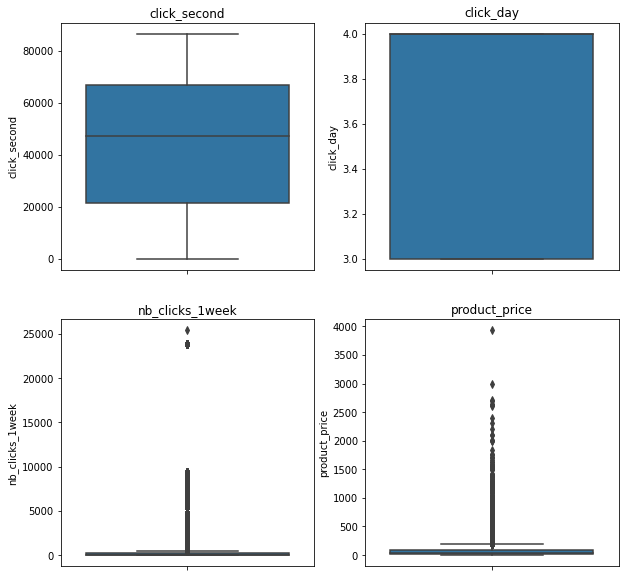

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for col, ax in zip(numerical_cols, axes.flatten()):
    ax.set_title(col)
    sns.boxplot(data=data, y=col, ax=ax)

Boxplots suggest a very small range for non-outlier values for nb_clicks_1week and product_price and if we remove outliers according to them, almost all of their value will be zero and we gain no information by using these features any more. So we choose to use 10000 and 2000 for their upper limits respectively.

In [18]:
nb_click_threshold = 10000
product_price_threshold = 2000
data.loc[(data['nb_clicks_1week'] > nb_click_threshold), 'nb_clicks_1week'] = np.nan
data.loc[(data['product_price'] > product_price_threshold), 'product_price'] = np.nan

Next, we drop rows and columns with too much NaNs:

In [19]:
col_threshold = 0.8
#Dropping categorical columns with missing value rate higher than threshold
dropping_columns = data[categorical_cols].columns[data[categorical_cols].isnull().mean() >= col_threshold]
categorical_cols = list(set(categorical_cols).difference(list(dropping_columns)))
data.drop(columns=dropping_columns, errors='ignore', inplace=True)

row_threshold = 0.6
# #Dropping rows with missing value rate higher than threshold
data = data.loc[data.isnull().mean(axis=1) < row_threshold]
data.shape

(76985, 19)

So this process droped $2$ columns and about $\frac{1}{4}$ of rows.  
We have three options for replacing NaN values in categorical columns.  
1. Replacing them with value that have maximum frequency in that column.  
2. Replacing them with median of their columns.
3. Introducing a new category, i.e., 'other' for them.  


For second option, there should be an order between values and here we don't have any order (even in ordinal features like product_age_group, we can't deduce their order because of hashed strings). And because of very high missing rate in our dataset, first option doesn't seem 

In [20]:
clean_df = data[numerical_cols]
numerical_cols_medians = clean_df.median()
clean_df.fillna(numerical_cols_medians, inplace=True)
categorical_cols_idmaxes = {}
for col in categorical_cols:
    idxmax_value = data[col].mode()[0]
    categorical_cols_idmaxes[col] = idxmax_value
    clean_df = clean_df.merge(data[col].apply(lambda s: pd.Series(
        {
            col: idxmax_value if pd.isna(s) else s,
            f'{col}_is_na':1 if pd.isna(s) else 0
        }
        )), left_index=True, right_index=True)
clean_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,click_second,click_day,nb_clicks_1week,product_price,product_country,product_country_is_na,audience_id,audience_id_is_na,product_id,product_id_is_na,product_brand,product_brand_is_na,device_type,device_type_is_na,product_category(1),product_category(1)_is_na,product_category(3),product_category(3)_is_na,product_title,product_title_is_na,user_id,user_id_is_na,product_gender,product_gender_is_na,product_category(4),product_category(4)_is_na,product_age_group,product_age_group_is_na,product_category(2),product_category(2)_is_na,partner_id,partner_id_is_na
0,14876.0,4.0,38.0,37.73,4,0,2107,1,32369,0,3310,1,0,0,0,1,615,1,4399,1,35688,0,6,1,579,1,2,1,66,1,161,0
1,6460.0,4.0,38.0,37.73,4,0,2107,1,11359,0,3310,1,0,0,0,1,615,1,4399,1,87847,0,6,1,579,1,2,1,66,1,161,0
2,60871.0,4.0,38.0,37.73,1,0,2107,1,31278,0,1124,0,2,0,0,0,615,1,7134,0,60599,0,7,0,579,1,2,0,113,0,16,0
3,74068.0,3.0,38.0,37.73,4,0,2107,1,1382,0,3310,1,1,0,0,1,615,1,4399,1,12945,0,6,1,579,1,2,1,66,1,161,0
4,75257.0,3.0,1064.0,37.73,6,0,2107,1,9323,0,2892,0,0,0,2,0,81,0,1072,0,8342,0,1,0,201,0,2,0,26,0,169,0


In [21]:
saved_mean = clean_df.mean()
saved_std = clean_df.std()
clean_df = (clean_df - saved_mean) / saved_std
clean_df

,click_second,click_day,nb_clicks_1week,product_price,product_country,product_country_is_na,audience_id,audience_id_is_na,product_id,product_id_is_na,product_brand,product_brand_is_na,device_type,device_type_is_na,product_category(1),product_category(1)_is_na,product_category(3),product_category(3)_is_na,product_title,product_title_is_na,user_id,user_id_is_na,product_gender,product_gender_is_na,product_category(4),product_category(4)_is_na,product_age_group,product_age_group_is_na,product_category(2),product_category(2)_is_na,partner_id,partner_id_is_na
0,-1.149873,0.851237,-0.246678,-0.120925,-0.264809,-0.098449,0.258351,0.62586,0.742721,-0.098449,0.390805,0.894055,-0.830246,NaN,-0.936439,1.556760,0.719859,1.275682,-0.809101,1.544093,-0.453513,NaN,0.314162,0.682119,0.251926,0.772632,-0.219155,0.681118,-0.138148,1.556027,0.838047,NaN
1,-1.479247,0.851237,-0.246678,-0.120925,-0.264809,-0.098449,0.258351,0.62586,-0.857254,-0.098449,0.390805,0.894055,-0.830246,NaN,-0.936439,1.556760,0.719859,1.275682,-0.809101,1.544093,1.412110,NaN,0.314162,0.682119,0.251926,0.772632,-0.219155,0.681118,-0.138148,1.556027,0.838047,NaN
2,0.650213,0.851237,-0.246678,-0.120925,-1.197365,-0.098449,0.258351,0.62586,0.659638,-0.098449,-1.768171,-1.118484,2.270163,NaN,-0.936439,-0.642351,0.719859,1.275682,-0.463946,-0.647621,0.437504,NaN,0.932582,-1.466001,0.251926,0.772632,-0.219155,-1.468156,1.398779,-0.642654,-2.081843,NaN
3,1.166698,-1.174746,-0.246678,-0.120925,-0.264809,-0.098449,0.258351,0.62586,-1.617033,-0.098449,0.390805,0.894055,0.719959,NaN,-0.936439,1.556760,0.719859,1.275682,-0.809101,1.544093,-1.266984,NaN,0.314162,0.682119,0.251926,0.772632,-0.219155,0.681118,-0.138148,1.556027,0.838047,NaN
4,1.213232,-1.174746,0.750847,-0.120925,0.356896,-0.098449,0.258351,0.62586,-1.012302,-0.098449,-0.022028,-1.118484,-0.830246,NaN,-0.627891,-0.642351,-1.970503,-0.783884,-1.228966,-0.647621,-1.431624,NaN,-2.777937,-1.466001,-1.995451,-1.294261,-0.219155,-1.468156,-1.446171,-0.642654,0.999144,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992,-1.484022,0.851237,-0.246678,-0.120925,-0.264809,-0.098449,0.258351,0.62586,0.283214,-0.098449,0.390805,0.894055,-0.830246,NaN,-0.936439,1.556760,0.719859,1.275682,-0.809101,1.544093,-0.004660,NaN,0.314162,0.682119,0.251926,0.772632,-0.219155,0.681118,-0.138148,1.556027,0.838047,NaN
99993,-1.513687,0.851237,-0.246678,-0.120925,-0.264809,-0.098449,0.258351,0.62586,-1.235126,-0.098449,0.390805,0.894055,-0.830246,NaN,-0.936439,1.556760,0.719859,1.275682,-0.809101,1.544093,0.940545,NaN,0.314162,0.682119,0.251926,0.772632,-0.219155,0.681118,-0.138148,1.556027,0.838047,NaN
99997,-0.545801,0.851237,-0.119313,-0.723549,-1.197365,-0.098449,0.685681,-1.59778,-0.251000,-0.098449,1.763621,-1.118484,-0.830246,NaN,1.531938,-0.642351,-1.658139,-0.783884,-0.211421,-0.647621,0.709269,NaN,0.314162,0.682119,-2.477032,-1.294261,-0.219155,0.681118,0.777468,-0.642654,-0.128537,NaN
99998,-1.275424,0.851237,-0.254456,-0.120925,-0.264809,-0.098449,-2.754426,-1.59778,1.254013,-0.098449,0.390805,0.894055,0.719959,NaN,0.143476,-0.642351,-2.207295,-0.783884,1.794138,-0.647621,-0.485704,NaN,0.314162,0.682119,0.251926,0.772632,-0.219155,0.681118,-1.184567,-0.642654,0.838047,NaN


In [22]:
nan_is_nan_cols = clean_df.columns[saved_std == 0]
clean_df.drop(columns=nan_is_nan_cols, errors='ignore', inplace=True)
clean_df

,click_second,click_day,nb_clicks_1week,product_price,product_country,product_country_is_na,audience_id,audience_id_is_na,product_id,product_id_is_na,product_brand,product_brand_is_na,device_type,product_category(1),product_category(1)_is_na,product_category(3),product_category(3)_is_na,product_title,product_title_is_na,user_id,product_gender,product_gender_is_na,product_category(4),product_category(4)_is_na,product_age_group,product_age_group_is_na,product_category(2),product_category(2)_is_na,partner_id
0,-1.149873,0.851237,-0.246678,-0.120925,-0.264809,-0.098449,0.258351,0.62586,0.742721,-0.098449,0.390805,0.894055,-0.830246,-0.936439,1.556760,0.719859,1.275682,-0.809101,1.544093,-0.453513,0.314162,0.682119,0.251926,0.772632,-0.219155,0.681118,-0.138148,1.556027,0.838047
1,-1.479247,0.851237,-0.246678,-0.120925,-0.264809,-0.098449,0.258351,0.62586,-0.857254,-0.098449,0.390805,0.894055,-0.830246,-0.936439,1.556760,0.719859,1.275682,-0.809101,1.544093,1.412110,0.314162,0.682119,0.251926,0.772632,-0.219155,0.681118,-0.138148,1.556027,0.838047
2,0.650213,0.851237,-0.246678,-0.120925,-1.197365,-0.098449,0.258351,0.62586,0.659638,-0.098449,-1.768171,-1.118484,2.270163,-0.936439,-0.642351,0.719859,1.275682,-0.463946,-0.647621,0.437504,0.932582,-1.466001,0.251926,0.772632,-0.219155,-1.468156,1.398779,-0.642654,-2.081843
3,1.166698,-1.174746,-0.246678,-0.120925,-0.264809,-0.098449,0.258351,0.62586,-1.617033,-0.098449,0.390805,0.894055,0.719959,-0.936439,1.556760,0.719859,1.275682,-0.809101,1.544093,-1.266984,0.314162,0.682119,0.251926,0.772632,-0.219155,0.681118,-0.138148,1.556027,0.838047
4,1.213232,-1.174746,0.750847,-0.120925,0.356896,-0.098449,0.258351,0.62586,-1.012302,-0.098449,-0.022028,-1.118484,-0.830246,-0.627891,-0.642351,-1.970503,-0.783884,-1.228966,-0.647621,-1.431624,-2.777937,-1.466001,-1.995451,-1.294261,-0.219155,-1.468156,-1.446171,-0.642654,0.999144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992,-1.484022,0.851237,-0.246678,-0.120925,-0.264809,-0.098449,0.258351,0.62586,0.283214,-0.098449,0.390805,0.894055,-0.830246,-0.936439,1.556760,0.719859,1.275682,-0.809101,1.544093,-0.004660,0.314162,0.682119,0.251926,0.772632,-0.219155,0.681118,-0.138148,1.556027,0.838047
99993,-1.513687,0.851237,-0.246678,-0.120925,-0.264809,-0.098449,0.258351,0.62586,-1.235126,-0.098449,0.390805,0.894055,-0.830246,-0.936439,1.556760,0.719859,1.275682,-0.809101,1.544093,0.940545,0.314162,0.682119,0.251926,0.772632,-0.219155,0.681118,-0.138148,1.556027,0.838047
99997,-0.545801,0.851237,-0.119313,-0.723549,-1.197365,-0.098449,0.685681,-1.59778,-0.251000,-0.098449,1.763621,-1.118484,-0.830246,1.531938,-0.642351,-1.658139,-0.783884,-0.211421,-0.647621,0.709269,0.314162,0.682119,-2.477032,-1.294261,-0.219155,0.681118,0.777468,-0.642654,-0.128537
99998,-1.275424,0.851237,-0.254456,-0.120925,-0.264809,-0.098449,-2.754426,-1.59778,1.254013,-0.098449,0.390805,0.894055,0.719959,0.143476,-0.642351,-2.207295,-0.783884,1.794138,-0.647621,-0.485704,0.314162,0.682119,0.251926,0.772632,-0.219155,0.681118,-1.184567,-0.642654,0.838047


In [23]:
def data_preprocess(data):
    int_cols = data.select_dtypes(int).columns
    data[int_cols] = data[int_cols].astype('Int64')
    data = data.drop(columns=['SalesAmountInEuro',	'time_delay_for_conversion'], errors='ignore')
    data = data.merge(data['click_timestamp'].apply(lambda s: pd.Series({'click_day':get_day(s), 'click_second':get_seconds(s)})), left_index=True, right_index=True)
    numerical_cols = ['click_second', 'click_day', 'nb_clicks_1week', 'product_price']
    categorical_cols = list(set(data.columns) - set(numerical_cols) - set([target]))
    data.drop(columns=['click_timestamp'], errors='ignore', inplace=True)
    data.drop(columns=['product_category(7)'], errors='ignore', inplace=True)
    categorical_cols = list(set(categorical_cols).difference(['product_category(7)']))
    data = data.replace([-1, '-1'], np.nan).replace({'product_price': 0}, np.nan)
    for col in categorical_cols:
        data[col] = pd.Categorical(data[col], column_categories[col]).codes
    data[categorical_cols] = data[categorical_cols].astype('Int64')
    data = data.replace(-1, np.nan)
    data.loc[(data['nb_clicks_1week'] > nb_click_threshold), 'nb_clicks_1week'] = np.nan
    data.loc[(data['product_price'] > product_price_threshold), 'product_price'] = np.nan
    categorical_cols = list(set(categorical_cols).difference(list(dropping_columns)))
    data.drop(columns=dropping_columns, errors='ignore', inplace=True)
    clean_df = data[numerical_cols]
    clean_df.fillna(numerical_cols_medians, inplace=True)
    for col in categorical_cols:
        clean_df = clean_df.merge(data[col].apply(lambda s: pd.Series(
            {
                col: categorical_cols_idmaxes[col] if pd.isna(s) else s,
                f'{col}_is_na':1 if pd.isna(s) else 0
            }
            )), left_index=True, right_index=True)
    clean_df = (clean_df - saved_mean) / saved_std
    clean_df.drop(columns=nan_is_nan_cols, errors='ignore', inplace=True)


# 2. Model Training

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import mlflow
import mlflow.pytorch
import pickle

from typing import Tuple
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [27]:
class SalePrediction(nn.Module):

    def __init__(self, input_size):
        super().__init__()
        #input
        self.input_size = input_size
        self.lnn = nn.Sequential(
            nn.Linear(self.input_size, 16),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(4, 2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(2, 1)
        )
        
    
    def forward(self, x: torch.tensor):
        x = x.view(-1, self.input_size)
        return self.lnn(x)

In [28]:
class SalePredictionDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i]

In [29]:
Y = data[target].to_numpy(dtype='float32')
X = clean_df.drop(columns=['product_price']).to_numpy(dtype='float32')

data_set = SalePredictionDataset(X, Y)
train_size = int(0.8 * len(data_set))
val_size = len(data_set) - train_size

train_set, val_set = torch.utils.data.random_split(data_set, (train_size, val_size))

train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=32, shuffle=False)

In [30]:
def train(model, criterion, optimizer, epoch):
    train_loss = 0
    N_train = len(train_loader.dataset)

    model.train()
    with tqdm.tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (x, y) in pbar:
            optimizer.zero_grad()

            x = x.to(device)
            y = y.view(-1, 1).to(device)
            p = model(x)

            loss = criterion(p, y)
            train_loss += loss.item() * len(x)

            pbar.set_description(f'Epoch:{epoch}, Train Loss: {train_loss / N_train:.3e}')
            
            loss.backward()
            optimizer.step()
    
    train_loss /= N_train
    mlflow.log_metric('train_loss', train_loss)
    return train_loss


def validate(model, criterion, epoch):
    val_loss = 0
    N_val = len(val_loader.dataset)

    model.eval()
    with torch.no_grad(), tqdm.tqdm(enumerate(val_loader), total=len(val_loader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.view(-1, 1).to(device)

            p = model(x)
            loss = criterion(p, y)
            val_loss += loss.item() * len(x)

            pbar.set_description(f'Epoch:{epoch}, Val Loss: {val_loss / N_val:.3e}')
    
    print('-------------------------------------------------------------------')
    val_loss /= N_val
    mlflow.log_metric('val_loss', val_loss)
    return val_loss

In [31]:
def do_expriment(lr, num_epochs):
    model = SalePrediction(X.shape[1]).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    with mlflow.start_run():
        mlflow.log_param('learning_rate', lr)
        mlflow.log_param('num_epochs', num_epochs)
        
        val_loss_min = float('inf')

        for epoch in range(num_epochs):
            train_loss = train(model, criterion, optimizer, epoch)
            val_loss = validate(model, criterion, epoch)

            if val_loss <= val_loss_min:
                torch.save(model.state_dict(), 'model.pt')
                val_loss_min = val_loss

        # load best model during different epochs
        model.load_state_dict(torch.load('model.pt'))

        # log trained model
        print("\nLogging the trained model as a run artifact...")
        mlflow.pytorch.log_model(model, artifact_path="pytorch-model", pickle_module=pickle)
        print('Logging the trained model is done')

        # metrics
        X_train, Y_train = train_set[:]
        X_val, Y_val = val_set[:]

        train_preds = model(X_train.to(device)).view(-1) >= 0
        val_preds = model(X_val.to(device)).view(-1) >= 0

        mlflow.log_metric('Train Precision', precision_score(Y_train, train_preds.cpu(), average='macro'))
        mlflow.log_metric('Train Recall' ,recall_score(Y_train, train_preds.cpu(), average='macro'))
        mlflow.log_metric('Train F1Score', f1_score(Y_train, train_preds.cpu()))

        mlflow.log_metric('val Precision', precision_score(Y_val, val_preds.cpu(), average='macro'))
        mlflow.log_metric('val Recall', recall_score(Y_val, val_preds.cpu(), average='macro'))
        mlflow.log_metric('val F1Score', f1_score(Y_val, val_preds.cpu()))

        return model

In [32]:
model = do_expriment(lr=10e-4, num_epochs=5)

Epoch:0, Val Loss: 4.056e-01: 100%|██████████| 482/482 [00:02<00:00, 182.48it/s]


-------------------------------------------------------------------


Epoch:1, Val Loss: 3.899e-01: 100%|██████████| 482/482 [00:02<00:00, 183.32it/s]


-------------------------------------------------------------------


Epoch:2, Val Loss: 3.840e-01: 100%|██████████| 482/482 [00:02<00:00, 177.51it/s]


-------------------------------------------------------------------


Epoch:3, Val Loss: 3.832e-01: 100%|██████████| 482/482 [00:02<00:00, 184.47it/s]


-------------------------------------------------------------------


Epoch:4, Val Loss: 3.812e-01: 100%|██████████| 482/482 [00:02<00:00, 185.53it/s]
2022/02/04 17:06:47 WARNING mlflow.utils.requirements_utils: Found torch version (1.10.0+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


-------------------------------------------------------------------

Logging the trained model as a run artifact...


2022/02/04 17:06:52 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp4pcf95on/model/data, flavor: pytorch), fall back to return ['torch==1.10.0', 'cloudpickle==1.3.0']. Set logging level to DEBUG to see the full traceback.


Logging the trained model is done


In [74]:
# !zip -r mlruns.zip ./mlruns/
!rm -rf mlruns

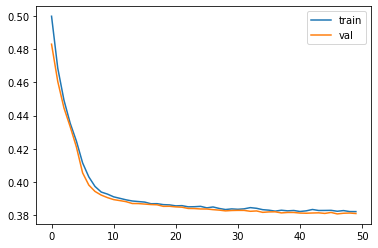

In [ ]:
plt.plot(train_loss_arr, label='train')
plt.plot(val_loss_arr, label='val')
plt.legend();

In [ ]:
# load the best model during epochs according to validation loss
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
def F1_score(model, X, Y):
    predictions = model(X).view(-1) >= 0

    TP = (predictions == Y).sum()
    FP = ((predictions == True) & (Y == False)).sum()
    FN = ((predictions == False) & (Y == True)).sum()

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    return precision, recall, (2 * precision * recall) / (precision + recall)


X_train, Y_train = train_set[:]
X_val, Y_val = val_set[:]

train_F1 = F1_score(model, X_train.to(device), Y_train.to(device))
val_F1 = F1_score(model, X_val.to(device), Y_val.to(device))
print(f'train -> precision:{train_F1[0]},\tRecall:{train_F1[1]},\tF1:{train_F1[2]}')
print(f'validation -> precision:{val_F1[0]},\tRecall:{val_F1[1]},\tF1:{val_F1[2]}')

train -> precision:1.0,	Recall:0.864389181137085,	F1:0.9272626042366028
validation -> precision:1.0,	Recall:0.8627654910087585,	F1:0.9263275265693665


# 3. XGBoost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score
import xgboost as xgb

In [ ]:
Y = data[target].to_numpy(dtype='float32')
X = clean_df.drop(columns=['product_price']).to_numpy(dtype='float32')
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

D_train = xgb.DMatrix(X_train, label=Y_train)
D_val = xgb.DMatrix(X_val, label=Y_val)

In [ ]:
param = {
    'eta': 0.3,
    'max_depth': 4,
    'objective': 'binary:logitraw'
}

step = 20

In [ ]:
model = xgb.train(param, D_train, step)

In [ ]:
preds = model.predict(D_val)
preds = preds > 0

# best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(Y_val, preds, average='macro')))
print("Recall = {}".format(recall_score(Y_val, preds, average='macro')))
print("Accuracy = {}".format(f1_score(Y_val, preds)))

Precision = 0.9259189316472459
Recall = 0.5371509057184716
Accuracy = 0.8650386438916672
